In [12]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from nipype.interfaces import fsl
from dicom2nifti.convert_dicom import dicom_series_to_nifti
import nibabel as nib
# import sigpy.plot as pl
import subtle.subtle_preprocess as supre
import SimpleITK as sitk

# %matplotlib notebook

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage', vmin=vmin, vmax=vmax)

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def dcm2nii(dcmdir, out_dir):
    out_file = '{}/{}.nii'.format(out_dir, dcmdir.split('/')[-1])
    dicom_series_to_nifti(dcmdir, out_file, reorient_nifti=False)
    return out_file

def npy2nii(fpath_npy, fpath_nii, mask=True, c_idx=0):
#     idx = 1 if mask else 0
    data = np.load(fpath_npy)[1, :, c_idx, ...] # [idx, :, c_idx, ...]
    data = data.transpose(1, 0, 2)
    data = np.rot90(data, k=3, axes=(1, 2))

    data_nii = nib.Nifti1Image(data, affine=np.eye(4))
    data_nii.to_filename(fpath_nii)
    return fpath_nii

def segment_tissue(fpath_input, fpath_outbase):
    fast_node = fsl.FAST()

    fast_node.inputs.in_files = fpath_input
    fast_node.inputs.out_basename = fpath_outbase
    fast_node.inputs.verbose = False
    fast_node.inputs.bias_lowpass = 4
    fast_node.inputs.no_bias = True
    fast_node.inputs.no_pve = True
    fast_node.inputs.segment_iters = 2
    fast_node.inputs.hyper = 0

    fast_node.cmdline
    out = fast_node.run()
    
    return nib.load('{}_seg.nii'.format(fpath_outbase)).get_data()

def nii2npy(fpath_nii):
    return nib.load(fpath_nii).get_data()

def sag2ax(input_npy):
    input_npy = input_npy.transpose(1, 0, 2)
    input_npy = np.rot90(input_npy, k=3, axes=(1, 2))
    return input_npy

<Figure size 864x720 with 0 Axes>

In [6]:
ref_img = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_256/NO26.npy')[1, :, 0, ...]
data_img = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data_256/NO70.npy')[1, :, 0, ...]

In [7]:
data_img_ax = sag2ax(data_img)

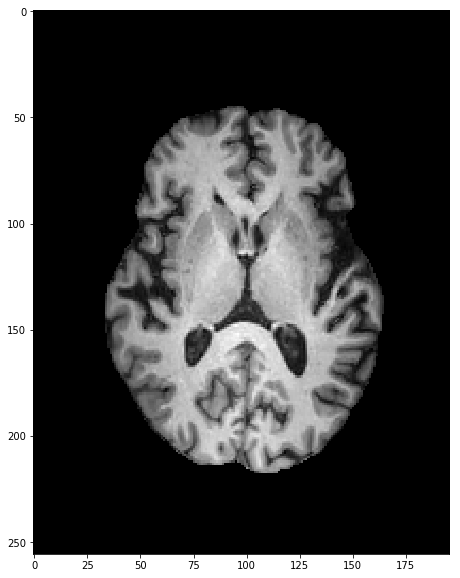

In [8]:
plt.imshow(data_img_ax[98])

In [27]:
fpath_nii = dcm2nii('/home/srivathsa/projects/studies/gad/tiantan/data/NO70/3DT1WMPRAGE_SAG_CS4_601', '/home/srivathsa/projects/')
print(fpath_nii)

/home/srivathsa/projects//3DT1WMPRAGE_SAG_CS4_601.nii


In [28]:
seg_npy = segment_tissue(fpath_nii, 'NO70')

200727-16:51:22,463 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [29]:
seg_masks = nii2npy('/home/srivathsa/projects/SubtleGad/train/notebooks/NO70_seg.nii')
print(seg_masks.shape)

(240, 240, 196)


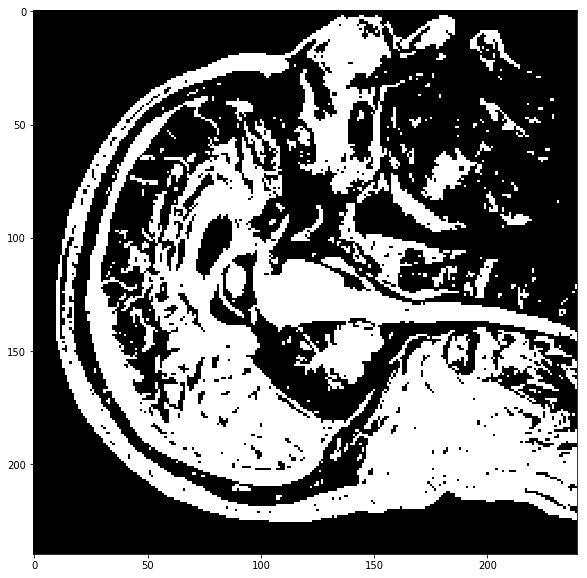

In [34]:
plt.imshow(seg_masks[... ,98] == 3)

In [16]:
pmap = sitk.GetDefaultParameterMap('affine')
data_img = supre.register_im(ref_img, data_img, param_map=pmap, return_params=False)

data_img = data_img * (data_img > 0.1)
data_img = np.clip(data_img, 0, data_img.max())
data_img = np.interp(data_img, (data_img.min(), data_img.max()), (ref_img.min(), ref_img.max()))
data_img = data_img.astype(ref_img.dtype)

print(ref_img.shape, ref_img.dtype, ref_img.min(), ref_img.max())
print(data_img.shape, data_img.dtype, data_img.min(), data_img.max())

image registration
registration done, 6.54 s
(196, 256, 256) float32 0.0 6.4599137
(196, 256, 256) float32 0.0 6.4599137


In [ ]:
np.save('ref_img.npy', ref_img)
np.save('data_img.npy', data_img)

In [ ]:
ref_nii = npy2nii('ref_img.npy', 'ref_img.nii')
data_nii = npy2nii('data_img.npy', 'data.nii')

In [ ]:
ref_seg_npy = segment_tissue(ref_nii, 'ref_tissue')
print(ref_seg_npy.shape)

In [ ]:
data_seg_npy = segment_tissue(data_nii, 'data_tissue')
print(data_seg_npy.shape)

In [ ]:
ref_seg_npy = nii2npy('ref_tissue_seg.nii')
data_seg_npy = nii2npy('data_tissue_seg.nii')

seg_idx = 1

ref_seg_wm = (ref_seg_npy == seg_idx)
data_seg_wm = (data_seg_npy == seg_idx)

ref_img_ax = sag2ax(ref_img)
data_img_ax = sag2ax(data_img)

pl.ImagePlot(data_seg_npy)

In [ ]:
data_seg_npy = nii2npy('data_tissue_seg.nii')

pl.ImagePlot(data_seg_npy == 3)